In [25]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
def process_aedt_and_monitor_data(working_dir):
    """
    Combines the steps of:
    1. Finding the .aedt file,
    2. Extracting monitor data from the .aedt file,
    3. Finding matching .sd files,
    4. Mapping monitor data to .sd files.

    Returns:
        tuple:
            - Path to the .aedt file
            - Path to the .aedt results monitor files directory
            - Dictionary of extracted monitor points with their IDs
            - Dictionary mapping monitor points to matching .sd file paths
    """

    # Step 1: Find the .aedt file within the working directory
    aedtfile_path = next((os.path.join(working_dir, f) for f in os.listdir(working_dir) if f.endswith(".aedt")), None)

    # If no .aedt file is found, raise an error
    if not aedtfile_path:
        raise FileNotFoundError("No .aedt file found in the current directory.")

    # Extract the file name without extension
    aedtfile_name = os.path.splitext(os.path.basename(aedtfile_path))[0]

    # Set path to the corresponding monitor files directory
    path_monfiles = os.path.join(working_dir, f"{aedtfile_name}.aedtresults", "IcepakDesign1.results")

    # Step 2: Extract monitor data from the .aedt file
    with open(aedtfile_path, 'r', encoding='latin1') as file:
        data = file.read()

    # Regular expression to capture the monitor block and its contents
    monitor_match = re.search(r"\$begin 'Monitor'\s*\$begin 'IcepakMonitors'(.*?)\$end 'IcepakMonitors'\s*\$end 'Monitor'", data, re.DOTALL)

    # Raise error if the monitor block is not found
    if not monitor_match:
        raise ValueError("Monitor block or IcepakMonitors block not found in the file.")

    # Extract monitor points and their corresponding IDs from the monitor block
    monitor_items = {block.group(1): int(re.search(r"ID=(\d+)", block.group(2)).group(1))
                      for block in re.finditer(r"\$begin '(.*?)'(.*?)\$end '\1'", monitor_match.group(1), re.DOTALL)}

    # Add "Residual" entry to the monitor items dictionary
    monitor_items = {"Residual": 0, **monitor_items}

    # Step 3: Find matching .sd files in the specified directory
    if not os.path.exists(path_monfiles):
        raise FileNotFoundError(f"The specified path does not exist: {path_monfiles}")

    # List all the .sd files that match the required pattern
    list_monfiles = [os.path.join(path_monfiles, f) for f in os.listdir(path_monfiles)
                     if re.match(r"DV\d+_S\d+_MON\d+_V0\.sd", f)]

    if not list_monfiles:
        raise FileNotFoundError("No matching .sd files found. Pre-processing is in progress, Please try again after 30 mins.")

    # Step 4: Map monitor points to matching .sd files using a regex pattern
    file_pattern = re.compile(r"DV\d+_S\d+_MON(\d+)_V0\.sd")

    # Create a dictionary of monitor points and their matching .sd files
    dict_monfiles = {key: next((file for file in list_monfiles if file_pattern.match(os.path.basename(file)) and
                               int(file_pattern.match(os.path.basename(file)).group(1)) == monitor_items[key]), None)
                     for key in monitor_items}

    return dict_monfiles


def parse_monfile_precise(file_path):
    """
    Parses a MON file with multiple possible structures:
    1. Iteration followed by variables in 'Variable(Value)' format.
    2. Iteration followed by a single 'Temperature(Value)' variable.

    Args:
        file_path (str): Path to the MON file.

    Returns:
        pd.DataFrame: A DataFrame with parsed data.
    """
    # Initialize lists for each possible column
    iteration_list = []
    temperature_list = []  # For Temperature structure
    continuity_list = []
    xvelocity_list = []
    yvelocity_list = []
    zvelocity_list = []
    energy_list = []
    dointensity_list = []
    jouleheating_list = []

    # Open the MON file and parse its content line by line
    with open(file_path, 'r') as file:
        for line in file:
            # Remove leading and trailing whitespaces
            line = line.strip()
            if not line:
                continue  # Skip empty lines

            # Split the line by the first whitespace
            # The first part is Iteration, and the rest contains variables
            parts = line.split(maxsplit=1)
            iteration = float(parts[0])  # Convert Iteration to float
            iteration_list.append(iteration)

            # Extract variables from the rest of the line
            rest = parts[1]

            # Initialize all variables to None (in case some are missing)
            temperature = continuity = xvelocity = yvelocity = zvelocity = energy = dointensity = jouleheating = None

            # Use regular expressions to find all occurrences of "VariableName(Value)"
            matches = re.findall(r"(\w+)\(([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)\)", rest)
            for var_name, var_value in matches:
                var_value = float(var_value)  # Convert value to float

                # Assign values to respective variables based on the variable name
                if var_name == "Temperature":
                    temperature = var_value
                elif var_name == "Continuity":
                    continuity = var_value
                elif var_name == "XVelocity":
                    xvelocity = var_value
                elif var_name == "YVelocity":
                    yvelocity = var_value
                elif var_name == "ZVelocity":
                    zvelocity = var_value
                elif var_name == "Energy":
                    energy = var_value
                elif var_name == "DOIntensity":
                    dointensity = var_value
                elif var_name == "JouleHeating":
                    jouleheating = var_value

            # Append the values to their respective lists
            temperature_list.append(temperature)
            continuity_list.append(continuity)
            xvelocity_list.append(xvelocity)
            yvelocity_list.append(yvelocity)
            zvelocity_list.append(zvelocity)
            energy_list.append(energy)
            dointensity_list.append(dointensity)
            jouleheating_list.append(jouleheating)

    # Combine all lists into a DataFrame
    df = pd.DataFrame({
        "Iteration": iteration_list,
        "Temperature": temperature_list,
        "Continuity": continuity_list,
        "XVelocity": xvelocity_list,
        "YVelocity": yvelocity_list,
        "ZVelocity": zvelocity_list,
        "Energy": energy_list,
        "DOIntensity": dointensity_list,
        "JouleHeating": jouleheating_list,
    })

    # Drop columns with all NaN values (e.g., Temperature if not present in this file)
    df = df.dropna(axis=1, how="all")

    return df

def make_combined_df(dict_monfiles):
    """
    Combines the monitor data from different .sd files into a single DataFrame based on 'Iteration'.

    Args:
        dict_monfiles (dict): Dictionary of monitor names and corresponding .sd file paths.

    Returns:
        pd.DataFrame: A DataFrame with the combined monitor data.
    """

    df_monfiles_total = None

    # Loop over each monitor file path in the dictionary
    for monitor_name, file_path in dict_monfiles.items():
        if file_path:
            try:
                # Parse the MON file into a DataFrame
                df = parse_monfile_precise(file_path)

                # If it's the "Residual" monitor, merge without changing column names
                if monitor_name == "Residual":
                    df_residual = df.copy()

                    if df_monfiles_total is None:
                        df_monfiles_total = df_residual
                    else:
                        df_monfiles_total = pd.merge(df_monfiles_total, df_residual, on='Iteration', how='outer')
                else:
                    # Rename the second column with the monitor name to avoid duplicate column names
                    df_non_residual = df.copy()
                    df_non_residual.rename(columns={df.columns[1]: f"{df.columns[1]}-{monitor_name}"}, inplace=True)

                    # Merge with the existing DataFrame
                    df_monfiles_total = pd.merge(df_monfiles_total, df_non_residual, on='Iteration', how='outer')

            except Exception as e:
                print(f"Check the error: {e}")

    return df_monfiles_total


def get_df():
    base_dir = os.path.dirname(os.getcwd())
    working_dir = os.path.join(base_dir, "tests")
    dict_monfiles = process_aedt_and_monitor_data(working_dir)

    df_monfiles_total = make_combined_df(dict_monfiles)

    return df_monfiles_total


In [27]:
df = get_df()
columns_list = df.columns.tolist()
columns_list    # You can check the columns of DataFrame, and use this dat for plotting

['Iteration',
 'Continuity',
 'XVelocity',
 'YVelocity',
 'ZVelocity',
 'Energy',
 'DOIntensity',
 'JouleHeating',
 'Temperature-BUSBAR1',
 'Temperature-BUSBAR2',
 'Temperature-BUSBAR3',
 'Temperature-BUSBAR4',
 'Temperature-BUSBAR5',
 'Temperature-BUSBAR6',
 'Temperature-BUSBAR7']

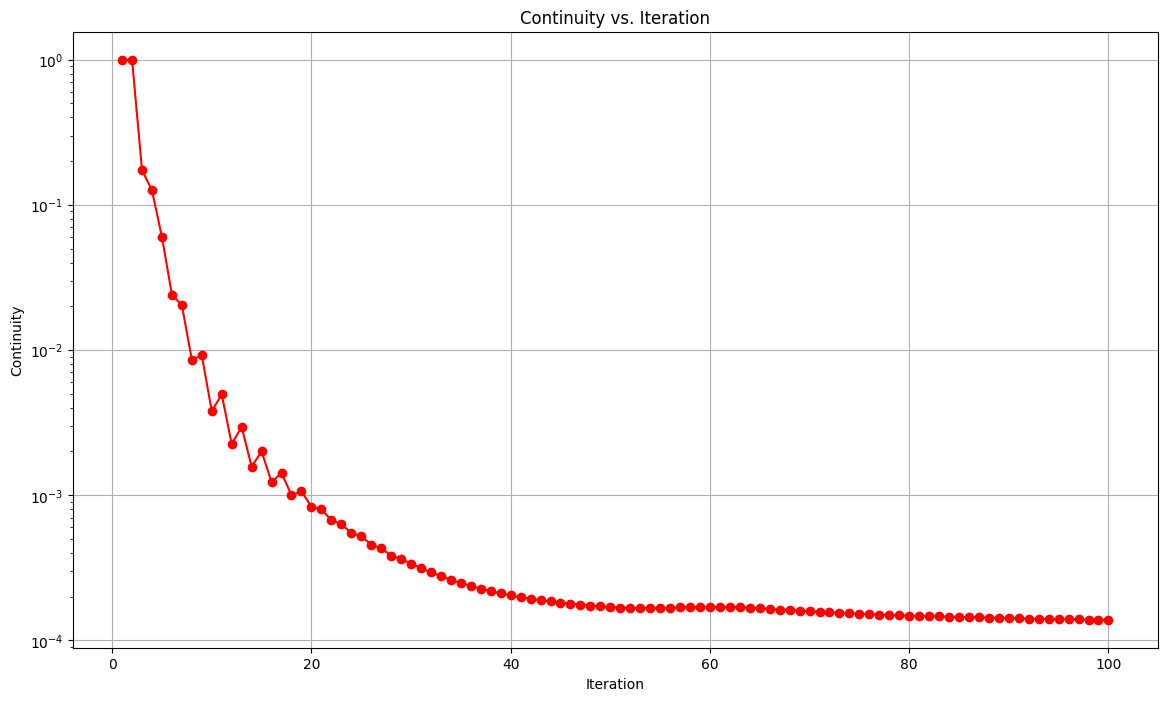

In [28]:
# This is example of plotting the single column (ex. Continuity)
plt.figure(figsize=(14, 8))
plt.grid(True)
plt.plot(df['Iteration'], df['Continuity'], marker="o", linestyle="-", color="red")

plt.yscale('log')
plt.title("Continuity vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Continuity")

plt.show()

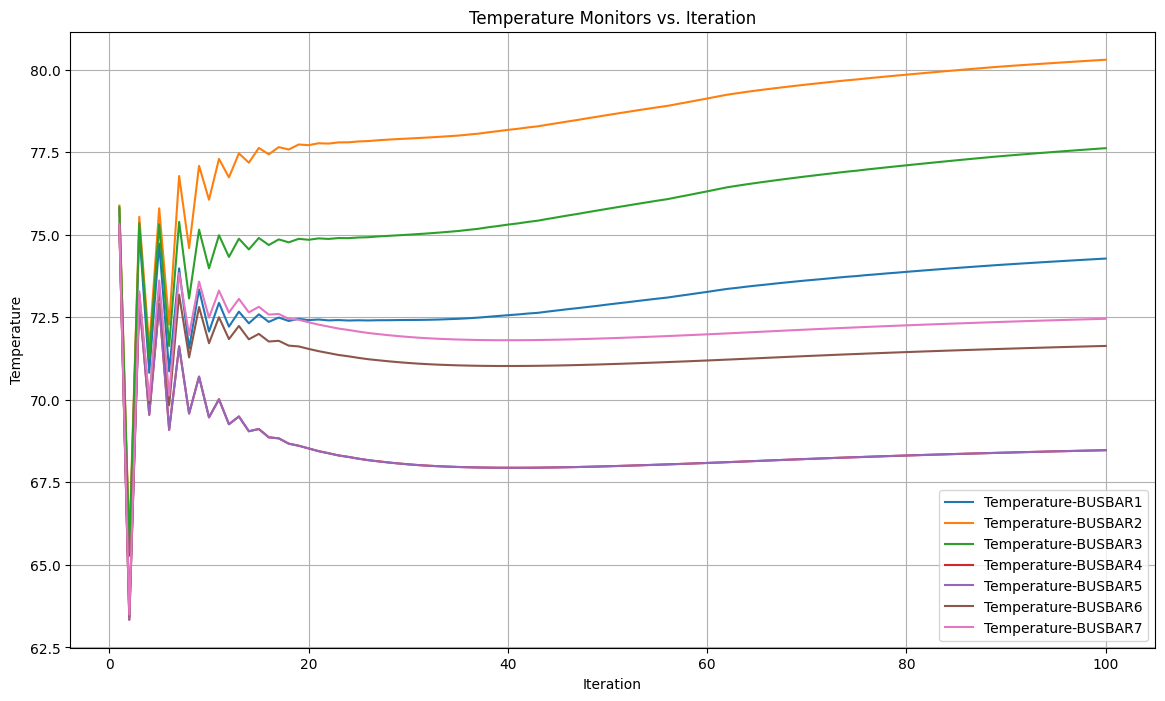

In [29]:
# This is example of plotting multiple columns (ex. 7 monitor points of temperature)
columns_to_plot = ['Temperature-BUSBAR1', 'Temperature-BUSBAR2', 'Temperature-BUSBAR3', 'Temperature-BUSBAR4', 'Temperature-BUSBAR5', 'Temperature-BUSBAR6', 'Temperature-BUSBAR7']
df.plot(x="Iteration", y=columns_to_plot, linestyle="-", figsize=(14, 8), grid=True)

plt.title("Temperature Monitors vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Temperature")

plt.show()